<a href="https://colab.research.google.com/github/AndriyBabiy/goit_deep-learning/blob/main/01_PyTorch_Fundamentals/01_PyTorch_Fundementals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 - Pytorch Basics

This project is focued on utilising neural networks in order to predict which factors impact the strength of concrete.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from collections import Counter

import warnings;
warnings.simplefilter('ignore')

## Import Libraries and Data

In [2]:
# Kaggle via Github
path_to_file = '/kaggle/input/01-pytorch-basics/01_PyTorch_Fundamentals/ConcreteStrengthData.csv'

# Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')
# path_to_file = '/content/drive/MyDrive/GoIT_Neoversity/deep_learning/ConcreteStrengthData.csv'

df = pd.read_csv(path_to_file)

In [3]:
df.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## Exploratory Data Analysis

In [4]:
df.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Based on the outline provided by the describe method it is evident that there are no missing values as all of the rows have similar amounts of datapoints. However, one thing that is noticable is that there are outliers in some of the rows as the maximum of the row seems to be greater than 3SD's above the mean.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Based on the above information it is also evident that the data is mainly of the numerical type.

In [6]:
target = 'Strength'
features = [col for col in df.columns if col != target]

print(f'Number of features: {len(features)}')
print('Features:', features)

Number of features: 8
Features: ['CementComponent ', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays']


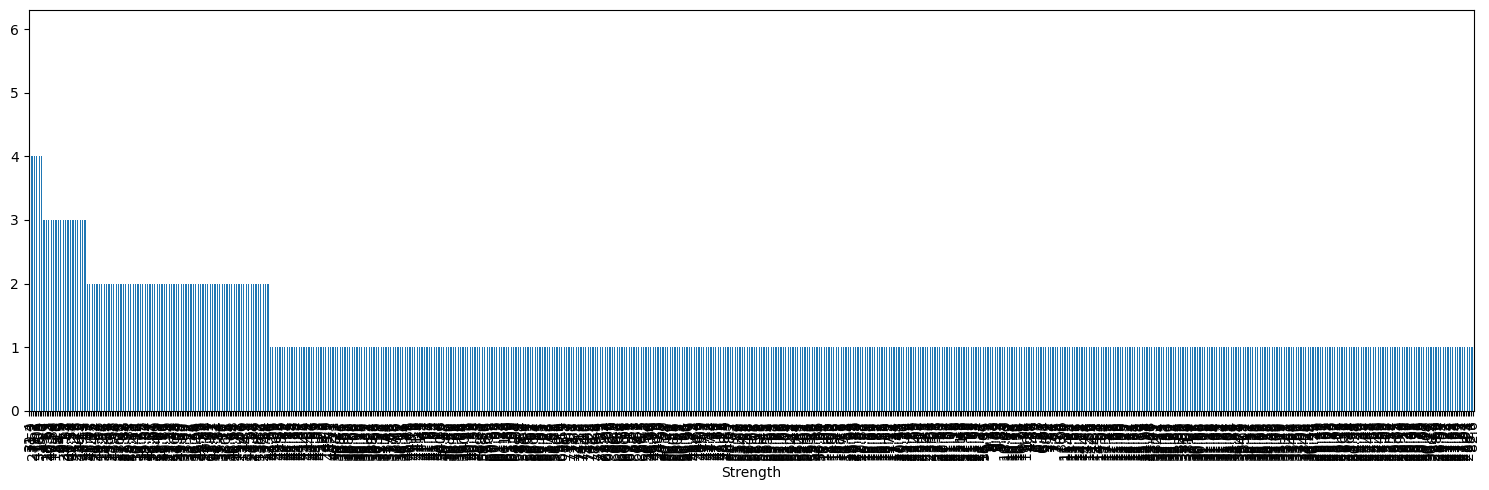

In [7]:
ax = df[target].sort_values().value_counts().plot(kind='bar', figsize=(15,5))

plt.tight_layout()
plt.show()

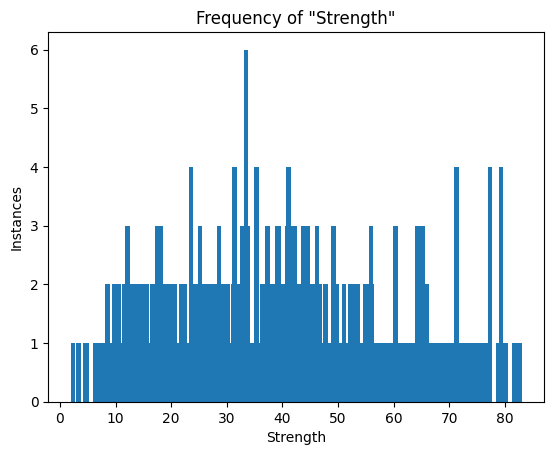

In [8]:
def target_dist(data_points):
  counter = Counter(data_points)

  sorted_data = sorted(counter.items())

  x_values, y_counts = zip(*sorted_data)

  plt.bar(x_values, y_counts)

  plt.xlabel(target)
  plt.ylabel('Instances')
  plt.title(f'Frequency of "Strength"')

  plt.show()

target_dist(df[target])

Based on the distribution of the target values it seems that there is a pattern of the strength distribution and that almost every value is unique, however there are some values that are seen more than once.

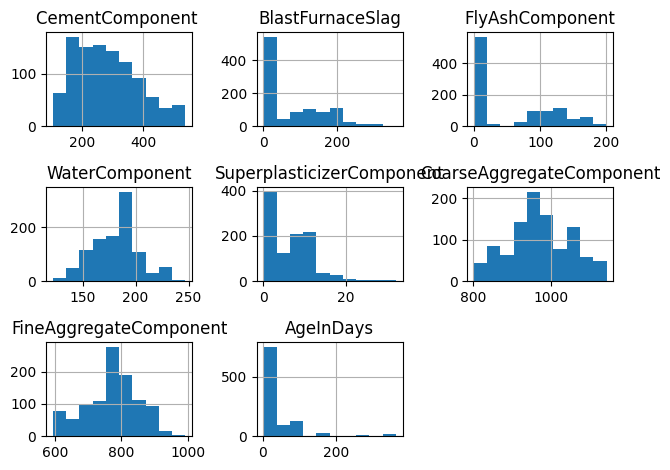

In [9]:
ax = df.loc[:, features].hist()

plt.tight_layout()
plt.show()

## Preparing the data for training

### Removing the outliers that have a z-score of over 3

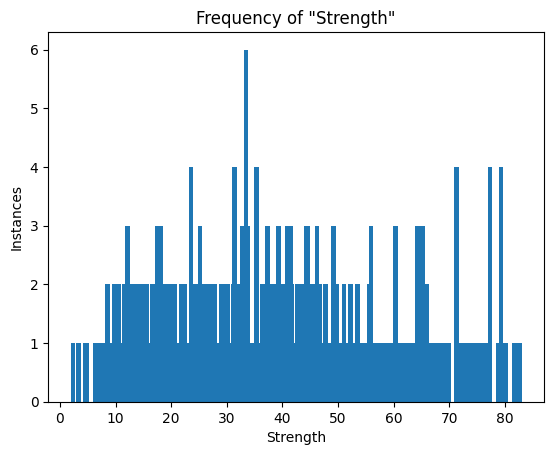

In [10]:
df_z_score= zscore(df, nan_policy='omit')
df_out = np.abs(df_z_score).ge(3).astype(int).mean(1)

out_indexes = df_out[df_out > 0].index

df_clean = df.drop(index=out_indexes)

target_dist(df_clean[target])

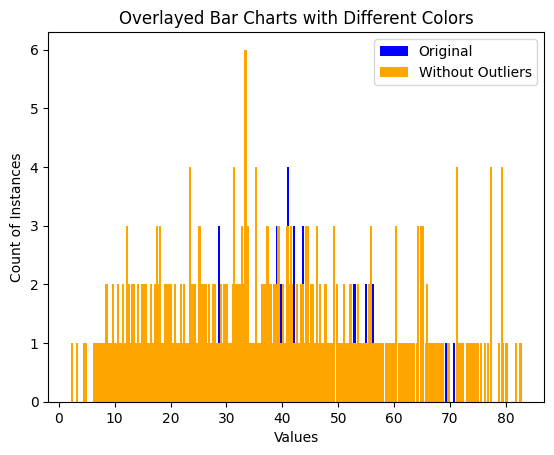

In [11]:
# Count the frequency of each value for both datasets
counter_1 = Counter(df[target])
counter_2 = Counter(df_clean[target])

# Sort the data based on the x-axis (values)
sorted_data_1 = sorted(counter_1.items())  # List of tuples (value, count)
sorted_data_2 = sorted(counter_2.items())  # List of tuples (value, count)

# Unpack the sorted values and counts
x_values_1, y_counts_1 = zip(*sorted_data_1)
x_values_2, y_counts_2 = zip(*sorted_data_2)

# Plotting the first dataset
plt.bar(x_values_1, y_counts_1, width=0.4, color='blue', align='center', label='Original')

# Plotting the second dataset with a slight shift on the x-axis for better visibility
plt.bar([x for x in x_values_2], y_counts_2, width=0.4, color='orange', align='center', label='Without Outliers')

# Adding labels, legend, and title
plt.xlabel('Values')
plt.ylabel('Count of Instances')
plt.title('Overlayed Bar Charts with Different Colors')
plt.legend()

# Display the plot
plt.show()

### Checking for covariance between the features

<Axes: >

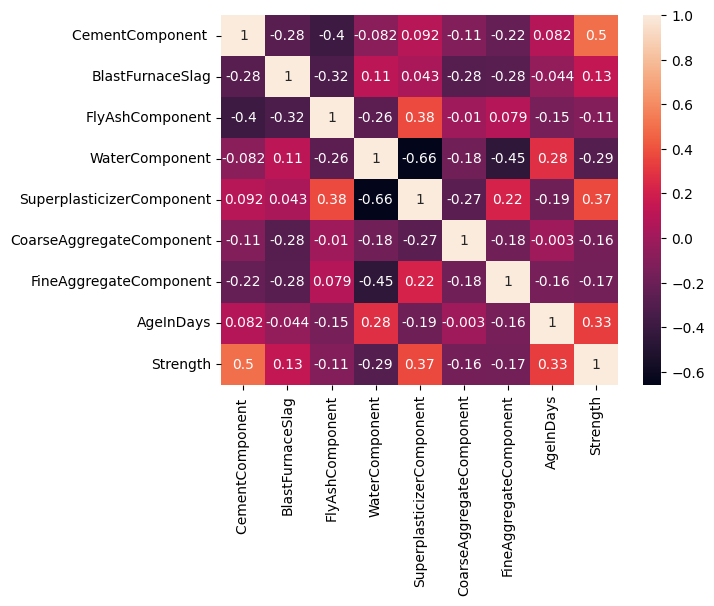

In [12]:
# =============================================================================
# Setting the df value
# =============================================================================
# df = df_clean
df = df # Based on the performance of the model the decision 

corr_matrix = df.corr()

sns.heatmap(corr_matrix,
            annot=True)

<Figure size 400x400 with 0 Axes>

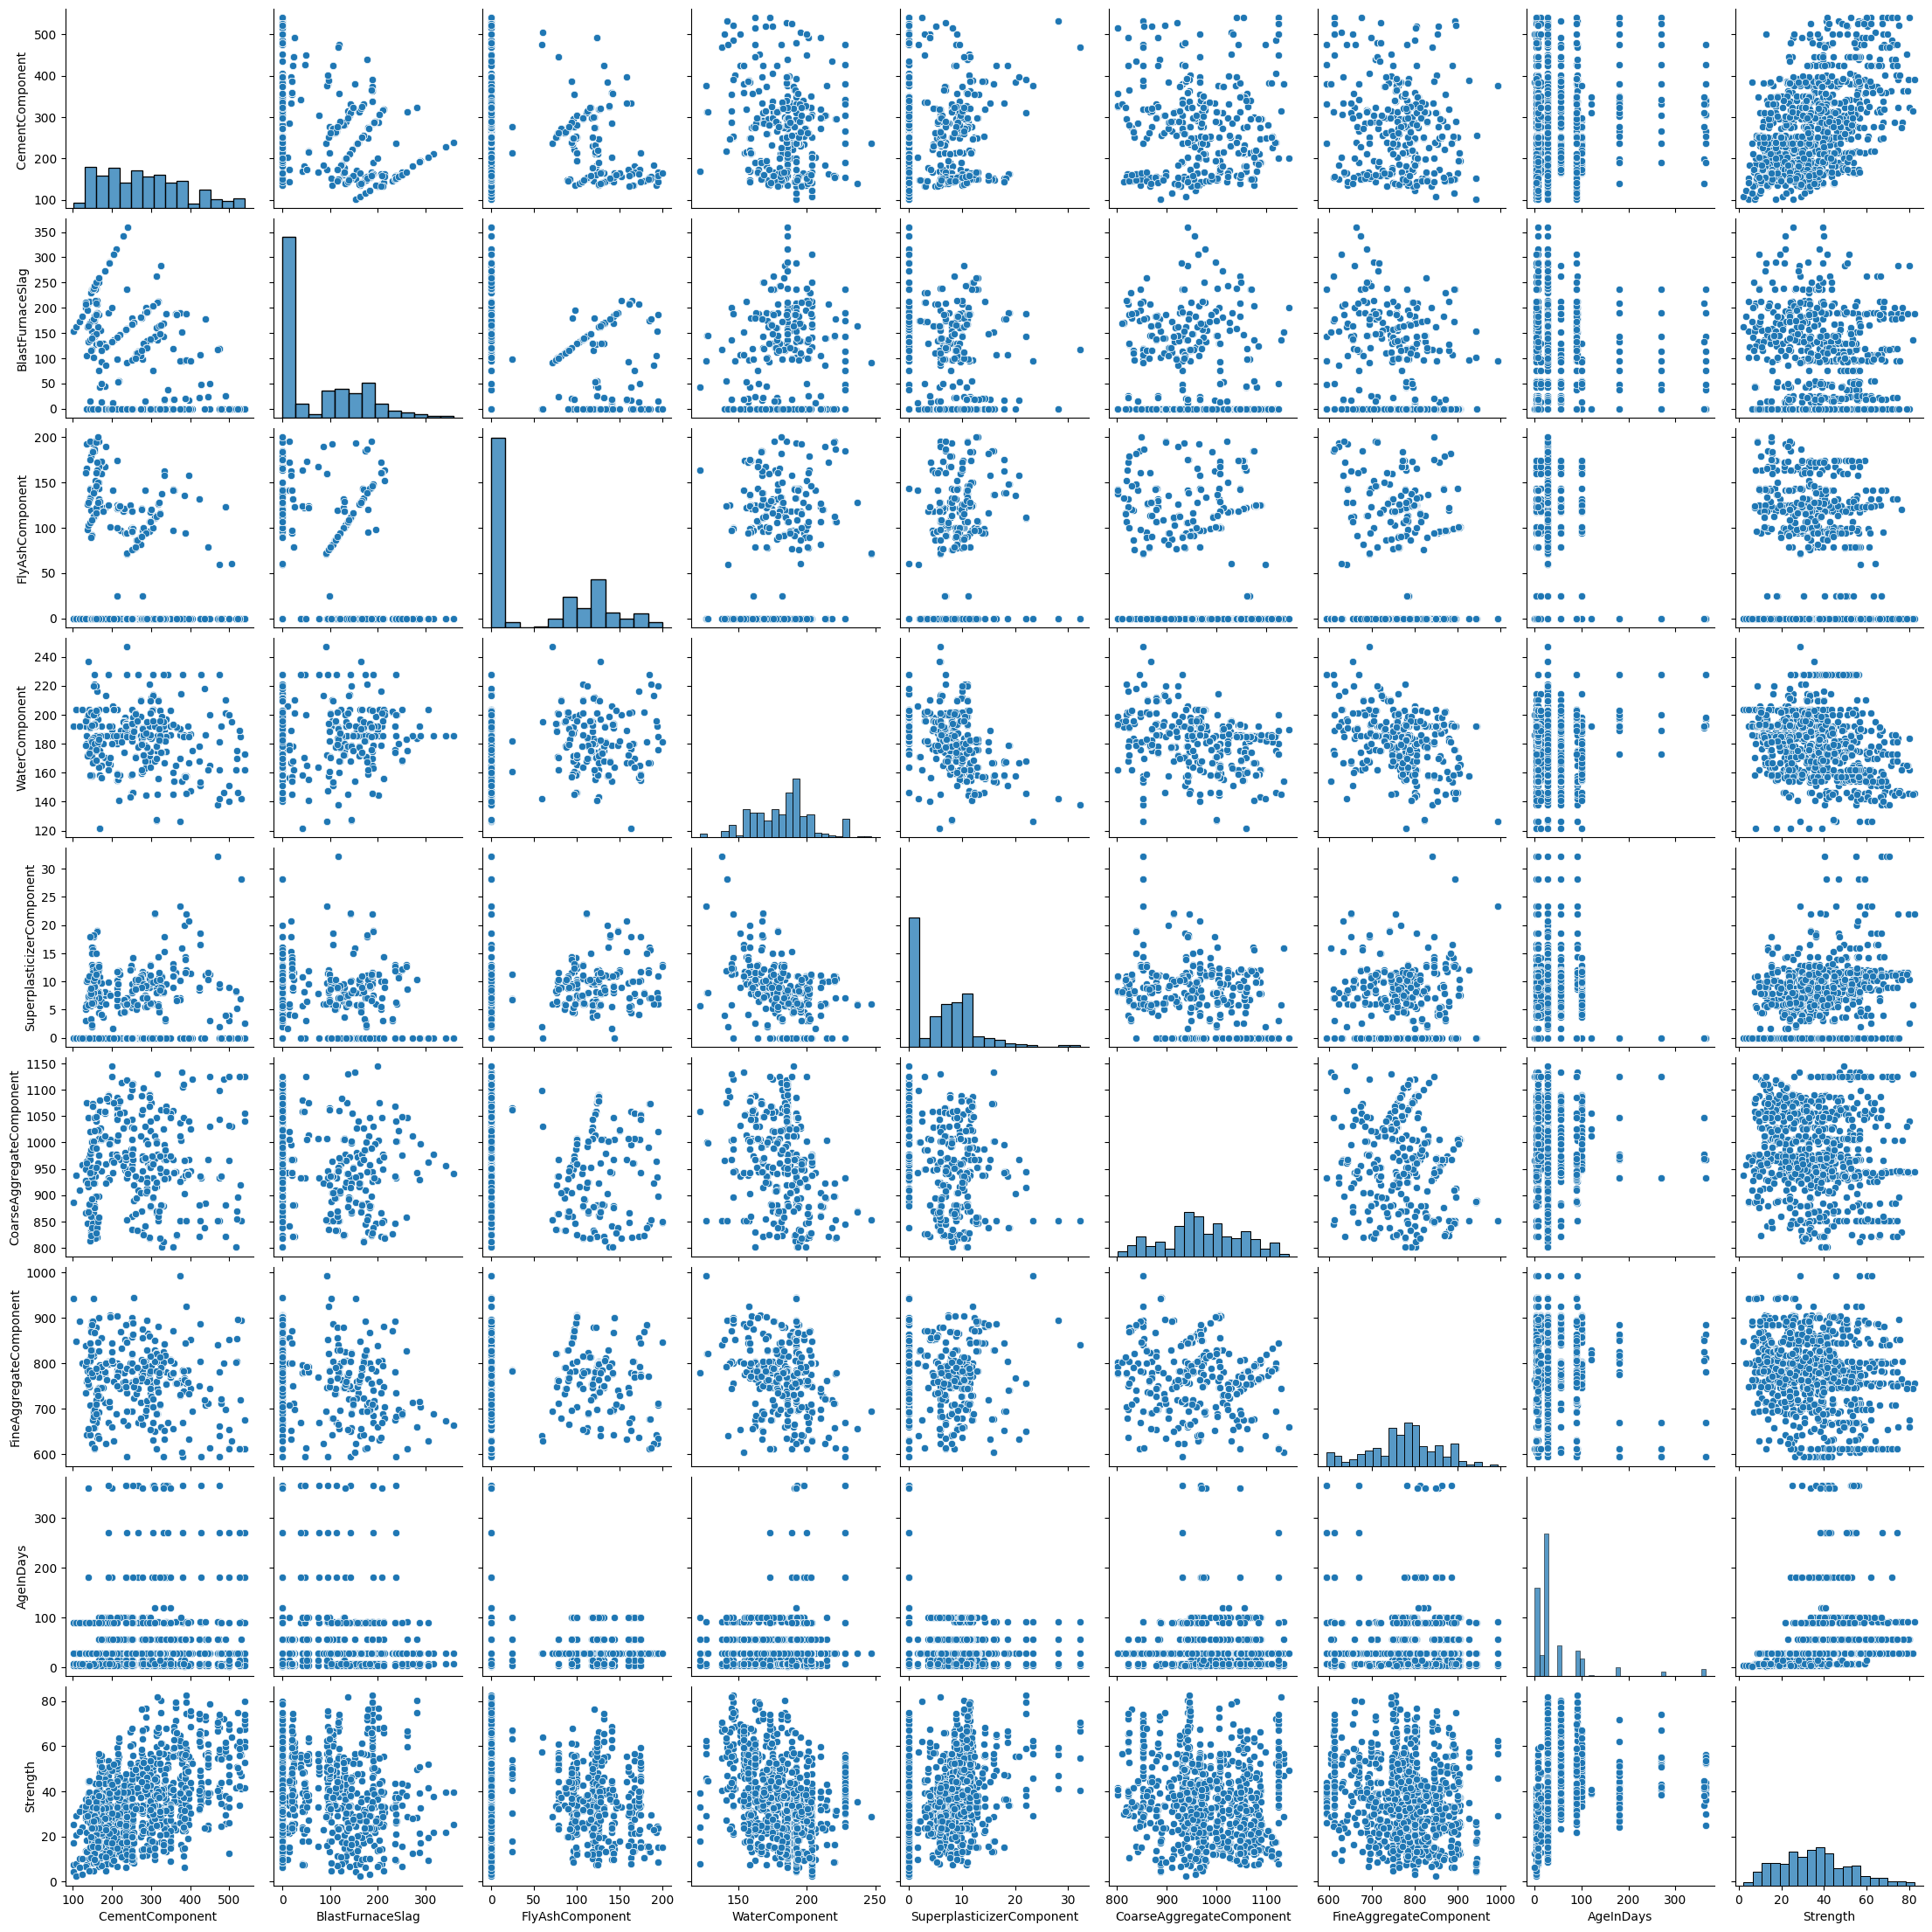

In [13]:
plt.figure(figsize=(4,4))
sns.pairplot(data=df)
plt.show()

From the correllation analysis it seems that there are no no features that correlate with others or features that correlate highly with the target. This allows us to proceed with the current data.

### Normalisation of the data set

In [14]:
# Scaling using Standard Scaler is performed in the ConcreteDataset class

### Splitting the Data into training and testing

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Strength', axis=1),
                                                    df['Strength'],
                                                    test_size=0.2,
                                                    random_state=42)

## Creating and Training the neural network to predict concrete strength

### Creating a class ConcreteDataset

In [16]:
class ConcreteDataset ( Dataset ):
  def __init__ (self, X, y, scale=True):
    self.X = X.values
    self.y=y.to_numpy()

    if scale:
      sc = StandardScaler()
      self.X = sc.fit_transform(self.X)

  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    X = torch.tensor(self.X[idx], dtype=torch.float64)
    y = torch.tensor(self.y[idx], dtype=torch.float64)

    return X, y


train_dataset = ConcreteDataset(X_train, y_train)
test_dataset = ConcreteDataset(X_test, y_test)

### Create the DataLoaders

In [17]:
train_dataloader = DataLoader(train_dataset,
                              batch_size= 100,
                              num_workers=4)

test_dataloader = DataLoader(test_dataset,
                             batch_size = 100,
                             num_workers=4)

In [18]:
next(iter(train_dataloader))

[tensor([[-1.1609e+00,  8.5739e-01,  9.8245e-01, -3.1429e-01,  1.4817e+00,
          -2.5746e-01, -6.4752e-01, -2.7567e-01],
         [ 1.3086e+00, -6.0249e-01,  1.2326e+00, -1.7819e-01,  3.9171e-01,
          -1.9269e+00, -2.7315e-01, -2.7567e-01],
         [-7.6865e-02, -8.5558e-01,  1.0669e+00, -1.0464e+00,  6.2647e-01,
           1.0179e+00,  6.6628e-02, -6.8931e-01],
         [-2.9181e-01,  2.6032e-01,  3.5708e-01,  5.7267e-01,  3.0787e-01,
          -1.7617e+00,  6.0409e-01, -2.7567e-01],
         [-1.0650e+00, -3.7011e-01,  1.1122e+00, -1.1027e+00,  7.7739e-01,
           1.3637e+00,  2.9768e-01, -6.8931e-01],
         [-9.4873e-01, -8.5558e-01,  1.7798e+00, -5.7239e-01,  2.4080e-01,
           1.0433e+00,  7.0335e-02, -2.7567e-01],
         [-1.1962e+00,  1.2543e+00, -8.3113e-01,  5.3982e-01,  4.9232e-01,
           9.3903e-01, -9.3170e-01, -2.7567e-01],
         [-9.8036e-01,  6.3766e-01,  1.0231e+00, -8.9028e-02, -4.2993e-01,
           4.2915e-01, -3.1269e-01,  1.8760e-01],


### Building the Linear Model

In [19]:
class LinearModel(torch.nn.Module):
  def __init__(self, in_dim, out_dim = 1):
    super().__init__()

    self.features = torch.nn.Sequential(
        nn.Linear(in_dim, 256),
        torch.nn.ReLU(),

        nn.Linear(256, 128),
        torch.nn.ReLU(),

        nn.Linear(128, 64),
        torch.nn.ReLU(),

        nn.Linear(64, out_dim),
    )

  def forward(self, x):
    output = self.features(x)
    return output

Initializing the model

In [20]:
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_losses = []
train_rmses = []
test_losses = []
test_rmses = []

In [21]:
num_epochs = 200

def RMSE(train, pred):
  return np.sqrt(mean_squared_error(train, pred))


for epoch in range(num_epochs):
  model.train()
  y_pred_train = []

  for data in train_dataloader:
    inputs, targets = data
    inputs, targets = inputs.float(), targets.float()
    targets = targets.reshape((targets.shape[0], 1))

    outputs = model(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_train.extend(outputs.cpu().detach().numpy())

  if (epoch+1) % 10 == 0:
    print(f'Train - Epoch [ {epoch+1} / {num_epochs}], Loss: {loss.item(): .4f}, RMSE: {RMSE(y_train, y_pred_train): .4f}, , r2: {r2_score(y_train, y_pred_train): .4f}')
  train_rmses.append(RMSE(y_train, y_pred_train))
  train_losses.append(loss.cpu().detach().numpy())


  model.eval()
  y_pred_test = []

  with torch.no_grad():
    for data in test_dataloader:
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      targets = targets.reshape((targets.shape[0], 1))

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      y_pred_test.extend(outputs.cpu().detach().numpy())

    test_rmses.append(RMSE(y_test, y_pred_test))
    test_losses.append(loss.cpu().detach().numpy())

Train - Epoch [ 10 / 200], Loss:  265.4588, RMSE:  14.4537, , r2:  0.2646
Train - Epoch [ 20 / 200], Loss:  166.4484, RMSE:  11.9763, , r2:  0.4951
Train - Epoch [ 30 / 200], Loss:  69.9237, RMSE:  8.6653, , r2:  0.7357
Train - Epoch [ 40 / 200], Loss:  39.3826, RMSE:  6.5439, , r2:  0.8493
Train - Epoch [ 50 / 200], Loss:  25.7331, RMSE:  5.8214, , r2:  0.8807
Train - Epoch [ 60 / 200], Loss:  17.6051, RMSE:  5.3217, , r2:  0.9003
Train - Epoch [ 70 / 200], Loss:  13.0564, RMSE:  4.9182, , r2:  0.9149
Train - Epoch [ 80 / 200], Loss:  10.0700, RMSE:  4.6172, , r2:  0.9250
Train - Epoch [ 90 / 200], Loss:  8.2595, RMSE:  4.3743, , r2:  0.9326
Train - Epoch [ 100 / 200], Loss:  6.7930, RMSE:  4.1694, , r2:  0.9388
Train - Epoch [ 110 / 200], Loss:  5.4156, RMSE:  3.9830, , r2:  0.9442
Train - Epoch [ 120 / 200], Loss:  4.4398, RMSE:  3.8192, , r2:  0.9487
Train - Epoch [ 130 / 200], Loss:  3.6350, RMSE:  3.6835, , r2:  0.9522
Train - Epoch [ 140 / 200], Loss:  3.0239, RMSE:  3.5699, , r

## Analyse the model performance

In [22]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()

        outputs = model(inputs)
        predictions.extend(outputs.tolist())
        actuals.extend(targets.tolist())

mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

MSE: 18.1779, RMSE: 4.2636, MAE: 3.6366, R²: 0.9403


On the first run of the model the results were as follows:
- MSE: 193.8193, RMSE: 13.9219, MAE: 11.5310, R²: 0.2652

These results were based on simply using the data to train the model (no additional feature engineering), the model ran for 100 epochs, with the MSELoss criterion and Adam optimiser at a learning rate of 1e-4.

Following this I increased the number of epochs and this resulted in an improvement in all of the scores bar the RMSE which became worse. Afer noticing this I decided to remove the filtering out of the outliers and this had a positive impact on the results relative to the original readings.
- MSE: 134.4495, RMSE: 11.5952, MAE: 10.2394, R²: 0.5587

Following this I decided to adjust the learning rate to 0.001. This is far greater than the original 1e-4. This had a tremendous impact on the resuls.
- MSE: 25.1329, RMSE: 5.0133, MAE: 4.2996, R²: 0.9175

This shows that in the original runs of the model the learning rate was far too small and was not coming near the minimum, whereas in the greater level of the learning rate there was a quicker movement towards the minimum. I also attempted to reintroduce the removal of the outliers, however this had an adverse affect on most of the metrics bar the MAE which improved and dropped to 3.91. The disimprovement in the other metrics showed that there was no need to remove the outliers and instead that they assisted in avoiding overtraining.

I then noticed that there were often runs of the model learning that resulted in inconsistent results. Some results were quite good, while others were not as good. In order to address this chance nature of the model having good and poor runs I decided to dectease the batch size from 200 to 100 in order to have more batches of a smaller size. This had a positive impact and resulted in the observed metrics as follows:
- MSE: 20.3510, RMSE: 4.5112, MAE: 3.5811, R²: 0.9332

Ultimately, Upon testing how a decrease in the number of epochs would impact the model I tried to see what kind of an impact this would have and that bringing the number of epochs below 200 resulted in a decreas of the overall metrics that brought the metrics outside of the goal of MSE < 35, MAE < 5 and R^2 > 0.8.

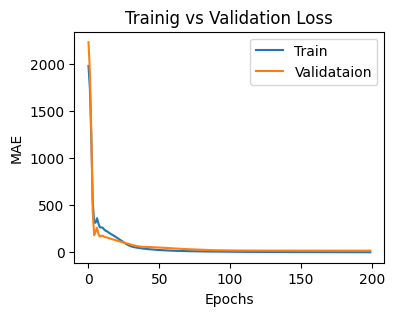

In [23]:
plt.figure(figsize=(4,3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Validataion')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Trainig vs Validation Loss')
plt.show()


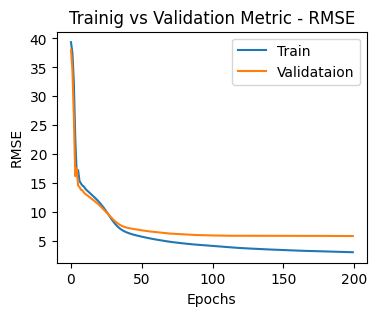

In [24]:
plt.figure(figsize=(4,3))
plt.plot(train_rmses, label='Train')
plt.plot(test_rmses, label='Validataion')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Trainig vs Validation Metric - RMSE')
plt.show()

## Conclusion and analysis of the results

Overall, from the analysis I have found that given the concrete dataset which has mainly numerical features and 1030 observations, and the goal of creating a model that can predict concrete strength using a neural network it is possible to build a model that accurately predicts using a linear regression model approach. 

After building the model, the model performed extremely well given 200 epochs, however this is dependant on having access to a GPU for training the model. Overall, the model did perform well an based on spending some time in the adjustment of hyperparameters as explained above it is possible to get the model to work well by using selective feature engineering and adjusting the number of epochs or learning rate.

The final metrics were chosen based on their ability to analyse the obsetved values from the model relative to the known target values. The metric used were MSE, RMSE, MAE and R^2 (R-squared).

**MSE**: 25.1329
This metric is included to track the severity to large errors. In the earlier training models when there was a smaller learning rate this figure was quite large and with the increased learning the model learned how to deal with the outliers more effectively.

**RMSE**: 5.0133
This metric was included as it shows the difference between the prediction and the actual value. This value is below the standard deviation for the target metric which also brings greater confidence in the model.

**MAE**: 4.2996
This metric was included as it also shows the difference between the prediction and the actual value and when joined with RMSE can indicate to the impact of large outliers. In our case the RMSE is not much greater than the MAE, however the 20% size difference does indicate that there are outliers present in the dataset, however this difference is not large enough to indicate that there are large regular errors occurring.

**R²**: 0.9175
The R-Squared metric showed that the model fits around 92% of the data

Further room for research can be in looking into how different models perform in the sequential setup in the LinearModel element as we currently use two hidden linear layers using the ReLU activation function.